# BirdCLEF 2023 - Audio Preprocessing 2
The goal here is to apply the guidelines and approach presented in the [First Steps, Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series of notebooks. Following that series, we'll look to use FastAI/PyTorch to create an effective validation set and iterate rapidly!

To overall plan is to start with transfer learning to train CNNs on spectrograms.

This notebook focuses on one-time audio preprocessing that will take place prior to creation of data loaders.

## Todo

 1. [ ] Complete Part 1
 2. [ ] Complete Part 2
 3. [ ] Complete Part 3
 4. [ ] Complete Part 4
 5. [ ] Try fastaudio for audio preprocessing [fastaudio]
 6. [ ] Try TorchAudio for audio preprocessing [torchaudio]
 7. [ ] Experiment with secondary labels

# Setup

## Download competition data and install packages
Prerequisites if running off of Kaggle:
1. Create a python environment
2. [Create `~/.kaggle/kaggle.json`](https://www.kaggle.com/docs/api)
3. [Join the competition](https://www.kaggle.com/competitions/birdclef-2023)

In [1]:
from fastkaggle import setup_comp

comp  = 'birdclef-2023'
comp_path = setup_comp(comp, install='fastai timm fastaudio')
comp_path.ls()

(#7) [Path('birdclef-2023/train_audio_prep-2'),Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep-1')]

## Load packages

In [2]:
from fastai.vision.all import *
import pandas as pd
import itertools
import torch
import torchaudio
import IPython.display
import mimetypes
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold
from fastaudio.core.all import *
from fastaudio.augment.all import *

print(torch.__version__, torchaudio.__version__)

/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


2.0.0+cu117 2.0.1+cu117


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

# Load Metadata

In [5]:
trn_path = comp_path/'train_audio_prep-1'
trn_path.ls()

(#264) [Path('birdclef-2023/train_audio_prep-1/somgre1'),Path('birdclef-2023/train_audio_prep-1/whcpri2'),Path('birdclef-2023/train_audio_prep-1/egygoo'),Path('birdclef-2023/train_audio_prep-1/woosan'),Path('birdclef-2023/train_audio_prep-1/yebapa1'),Path('birdclef-2023/train_audio_prep-1/hamerk1'),Path('birdclef-2023/train_audio_prep-1/hartur1'),Path('birdclef-2023/train_audio_prep-1/rebfir2'),Path('birdclef-2023/train_audio_prep-1/strher'),Path('birdclef-2023/train_audio_prep-1/wtbeat1')...]

## Provided Metadata

In [6]:
trn_df = pd.read_csv(comp_path/'train_metadata.csv')
lst_cols = ['secondary_labels', 'type']
for col in lst_cols:
    trn_df[col] = trn_df[col].apply(lambda x: x[1:-1].split(','))
    
trn_df.head().T

,0,1,2,3,4
primary_label,abethr1,abethr1,abethr1,abethr1,abethr1
secondary_labels,[],[],[],[],[]
type,['song'],['call'],['song'],['song'],"['call', 'song']"
latitude,4.3906,-2.9524,-2.9524,-2.9524,-2.9524
longitude,38.2788,38.2921,38.2921,38.2921,38.2921
scientific_name,Turdus tephronotus,Turdus tephronotus,Turdus tephronotus,Turdus tephronotus,Turdus tephronotus
common_name,African Bare-eyed Thrush,African Bare-eyed Thrush,African Bare-eyed Thrush,African Bare-eyed Thrush,African Bare-eyed Thrush
author,Rolf A. de By,James Bradley,James Bradley,James Bradley,James Bradley
license,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0
rating,4.0,3.5,3.5,5.0,4.5


# Audio Preprocessing

Here, we will preprocess audio and save new files. In part 1, we removed silence and resampled the audio. Here, we will resize audio to the same length.

In [7]:
prep_path = comp_path/'train_audio_prep-2b'
prep_path.mkdir(exist_ok=True)

## Create Augmentation Pipeline

Initially, I'm not resizing. I want to see the distribution of sizes after removing silence before deciding what length of audio to use.

In [8]:
# cfg = AudioConfig.BasicSpectrogram()
# aud2spec = AudioToSpec.from_cfg(cfg)
resize = ResizeSignal(duration=30e3)
pipe = Pipeline([resize])

## Preprocess

In [9]:
preprocess_audio_folder(trn_path, output_dir=prep_path, pipeline=pipe)

  0%|          | 0/16941 [00:00<?, ?it/s]

Path('birdclef-2023/train_audio_prep-2b')

## Check Audio Lengths

In [10]:
# audio_prep_md_df = get_audio_files_metadata(get_audio_files(prep_path))
audio_prep_md_df = get_audio_files_metadata(trn_df.filename, parent=prep_path)

Extracting audio metadata:   0%|          | 0/16941 [00:00<?, ?it/s]

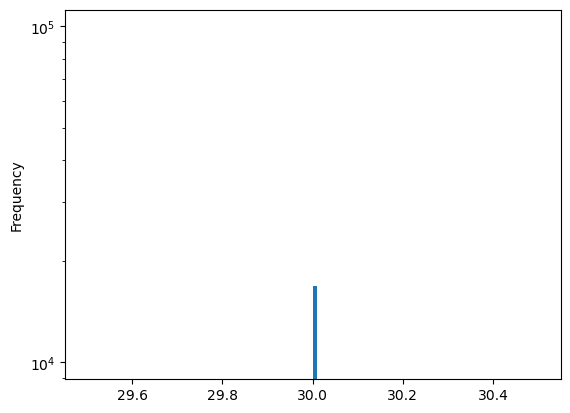

In [11]:
_ = audio_prep_md_df.seconds.plot.hist(logy=True, bins=100)

In [12]:
audio_prep_md_df.describe()

,sample_rate,num_frames,num_channels,bits_per_sample,seconds
count,16941.0,16941.0,16941.0,16941.0,16941.0
mean,16000.0,480000.0,1.0,0.0,30.0
std,0.0,0.0,0.0,0.0,0.0
min,16000.0,480000.0,1.0,0.0,30.0
25%,16000.0,480000.0,1.0,0.0,30.0
50%,16000.0,480000.0,1.0,0.0,30.0
75%,16000.0,480000.0,1.0,0.0,30.0
max,16000.0,480000.0,1.0,0.0,30.0


# Datablock
Confirm that we can create a data block.

In [13]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=hypp['n_fft'])
a2s = AudioToSpec.from_cfg(cfg)

NameError: name 'hypp' is not defined

In [ ]:
def _get_label(df, label_col):
    return df[label_col]

get_label = partial(_get_label, label_col='primary_label')

In [ ]:
db = DataBlock(blocks=(AudioBlock, CategoryBlock),
               get_x=ColReader('filename', pref=prep_path),
               # get_y=parent_label,
               get_y=get_label,
               splitter=IndexSplitter(test_index),
               batch_tfms = [a2s])

In [ ]:
db.summary(trn_df)

In [ ]:
dls = db.dataloaders(trn_df, bs=64)

In [ ]:
dls.show_batch(max_n=20)

In [ ]:
dls.show_batch()

# Dataloaders


# References

[fastaudio]: Coultas Blum, Harry A, Lucas G. Scart, and Robert Bracco. 2020.
“Fastaudio.” *GitHub*. <https://github.com/fastaudio/fastaudio>.

# Further Exploration

* [TorchAudio](https://pytorch.org/audio/stable/feature_classifications.html)
* Use more of fastkaggle https://fastai.github.io/fastkaggle/
* FastAudio: https://colab.research.google.com/github/fastaudio/fastaudio/blob/master/docs/ESC50:%20Environmental%20Sound%20Classification.ipynb#scrollTo=6T8g4m4h3hNq

* One challenge with the dataset here is we have training audio of varying length with lots of quiet periods between bird calls. When we divide up a training audio signal, some pieces will not have bird calls and we don't want to assign the label(s) of the entire file to each piece. We could try multiple instance learning to deal with this. 

* Training audio with multiple labels may further complicate training. Can we start with multiple instance learning using only the training sets with single labels and then use that model to divide our multiple instances into groups with different labels for further training?

* Try TorchAudio pre-trained models as a backbone

* One-hot-encode extras? https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list